In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Fixed import
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the data directory path
DATA_DIR = "./YOLO"  # You need to specify this path

IMG_SIZE = (256, 256)
BATCH_SIZE = 30

def load_data(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    # Create a dictionary to map label indices to class names
    label_to_class_map = {i: name for i, name in enumerate(class_names)}
    
    print("Class mapping:")
    for label, class_name in enumerate(class_names):
        print(f"Label {label}: {class_name}")
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                if os.path.isfile(file_path):  # Check that it's a file
                    image_paths.append(file_path)
                    labels.append(label)

    return np.array(image_paths), np.array(labels), label_to_class_map

def preprocess_image(image_path, label):
    try:
        image_path_str = image_path.numpy().decode()
        image = load_img(image_path_str, target_size=IMG_SIZE, color_mode='grayscale')
        image = img_to_array(image) / 255.0
        return image.astype(np.float32), label
    except Exception as e:
        print(f"Error processing image {image_path_str}: {e}")
        # Return a blank image in case of error
        return np.zeros((*IMG_SIZE, 1), dtype=np.float32), label

def tf_preprocess(image_path, label):
    image, label = tf.py_function(preprocess_image, [image_path, label], [tf.float32, tf.int32])
    image.set_shape([*IMG_SIZE, 1])  # Because grayscale
    label.set_shape([])  # Ensure label shape is set
    return image, label

def prepare_dataset(image_paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    ds = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Step 4: Split dataset
def main():
    # Make sure DATA_DIR exists
    if not os.path.exists(DATA_DIR):
        raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
        
    image_paths, labels, label_to_class_map = load_data(DATA_DIR)
    
    if len(image_paths) == 0:
        raise ValueError("No images found in the data directory")
    
    print(f"Total images: {len(image_paths)}")
    
    # Count images per class
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        class_name = label_to_class_map[label]
        print(f"Class {class_name} (Label {label}): {count} images")

    # First split: Train (70%) + Temp (30%)
    X_train, X_temp, y_train, y_temp = train_test_split(
        image_paths, labels, test_size=0.30, random_state=42, stratify=labels
    )

    # Second split: Validation (20%), Test (10%) from Temp
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1/3), random_state=42, stratify=y_temp
    )

    print(f"Train set: {len(X_train)} images")
    print(f"Validation set: {len(X_val)} images")
    print(f"Test set: {len(X_test)} images")

    # Prepare datasets
    train_ds = prepare_dataset(X_train, y_train)
    val_ds = prepare_dataset(X_val, y_val)
    test_ds = prepare_dataset(X_test, y_test)
    
    return train_ds, val_ds, test_ds, len(unique_labels), label_to_class_map

if __name__ == "__main__":
    train_ds, val_ds, test_ds, num_classes, label_to_class_map = main()
    
    print("\nLabel to class mapping:")
    for label, class_name in label_to_class_map.items():
        print(f"Label {label}: {class_name}")

Class mapping:
Label 0: Left YL
Label 1: RIGHT YL
Total images: 600
Class Left YL (Label 0): 300 images
Class RIGHT YL (Label 1): 300 images
Train set: 420 images
Validation set: 120 images
Test set: 60 images

Label to class mapping:
Label 0: Left YL
Label 1: RIGHT YL


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape=(256, 256, 1)):
    l2_reg = regularizers.l2(0.001)

    model = Sequential([
        Conv2D(16, (3,3), activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
        MaxPooling2D(2,2),
        
        Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2_reg),
        MaxPooling2D(2,2),
        
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2_reg),
        Dropout(0.5),
        Dense(1, activation='sigmoid', kernel_regularizer=l2_reg)
    ])
    
    # Fixed learning rate
    optimizer = Adam(learning_rate=0.001)  # Good range between 0.0001 to 0.001
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn_model()
model.summary()



c:\Users\vince\Downloads\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     7,872,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,877,441 (30.05 MB)

 Trainable params: 7,877,441 (30.05 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, val_acc_threshold=75.0, patience=4):
        super(CustomEarlyStopping, self).__init__()
        self.val_acc_threshold = val_acc_threshold
        self.patience = patience
        self.wait = 0
        self.best_val_acc = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy') * 100

        print(f"Epoch {epoch + 1}: Val Acc: {val_acc:.2f}%")

        # Check if improvement
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.wait = 0  # reset patience counter
        else:
            self.wait += 1
            print(f"No improvement. Patience counter: {self.wait}/{self.patience}")

            if self.wait >= self.patience:
                print(f"Early stopping triggered! Best Val Acc: {self.best_val_acc:.2f}%")
                self.model.stop_training = True

# Instantiate the callback
early_stop = CustomEarlyStopping(val_acc_threshold=75.0, patience=8)




In [5]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stop],
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.4737 - loss: 1.7531Epoch 1: Val Acc: 50.00%
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.4745 - loss: 1.7238 - val_accuracy: 0.5000 - val_loss: 0.7888
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.4556 - loss: 0.8046Epoch 2: Val Acc: 50.00%
No improvement. Patience counter: 1/8
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.4557 - loss: 0.8040 - val_accuracy: 0.5000 - val_loss: 0.7765
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5339 - loss: 0.7699Epoch 3: Val Acc: 50.83%
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5356 - loss: 0.7696 - val_accuracy: 0.5083 - val_loss: 0.7627
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5270 - loss: 0.7648Epoch 4: Val Acc: 64.17%
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.5294 - loss: 0.7644 - val_accuracy: 0.6417 - val_loss: 0.7507
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - 

In [6]:
# Evaluate the model's performance on the validation dataset
loss, accuracy = model.evaluate(test_ds)

# Print the accuracy
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7333 - loss: 0.6088
Validation Accuracy: 73.33%


In [7]:
def evaluate_model(model, test_ds, label_to_class_map):
    # Get predictions on the test dataset
    print("Making predictions on test dataset...")
    predictions = model.predict(test_ds)
    
    # For binary classification (assuming output is a single sigmoid unit)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    
    # Extract true labels from the test dataset
    print("Extracting true labels...")
    true_labels = []
    for images, labels in test_ds:
        true_labels.append(labels.numpy())
    true_labels = np.concatenate(true_labels, axis=0)
    
    # Calculate the evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    # Print the evaluation metrics
    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print confusion matrix for additional insight
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Display sample predictions
    print("\nSample Predictions:")
    sample_count = min(5, len(true_labels))
    for i in range(sample_count):
        true_class = label_to_class_map[true_labels[i]]
        pred_class = label_to_class_map[predicted_labels[i]]
        print(f"Image {i+1}: True class = {true_class}, Predicted class = {pred_class}")
    
    return accuracy, precision, recall, f1
print("\nEvaluating model performance...")
accuracy, precision, recall, f1 = evaluate_model(model, test_ds, label_to_class_map)


Evaluating model performance...
Making predictions on test dataset...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Extracting true labels...

Model Performance Metrics:
Accuracy: 0.7333
Precision: 0.7059
Recall: 0.8000
F1 Score: 0.7500

Confusion Matrix:
[[20 10]
 [ 6 24]]

Sample Predictions:
Image 1: True class = Left YL, Predicted class = Left YL
Image 2: True class = RIGHT YL, Predicted class = Left YL
Image 3: True class = RIGHT YL, Predicted class = RIGHT YL
Image 4: True class = Left YL, Predicted class = RIGHT YL
Image 5: True class = RIGHT YL, Predicted class = Left YL


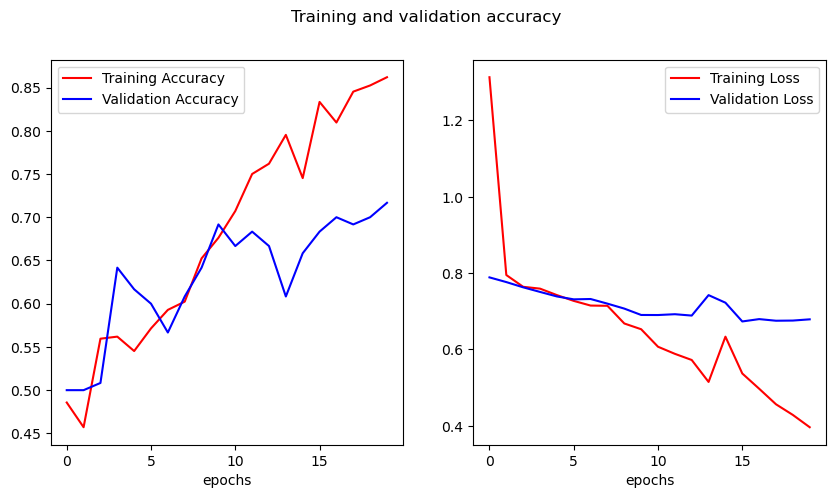

In [9]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [10]:
model.save("cnnyolomodel3.h5")